# Multiple Lenses Sequence

A more complex example of a system with multiple lenses in sequence. The number of lenses of each type is a easy to change parameter.

Lens design
Square size 30
Lens radius 21.213203435596427
Configuration 1 1 0
lens_min_thickness 1.2
lens_spacing 3.0
rays aperture 0.0
rays aperture 0.0
rays aperture 0.17624855
rays aperture 0.43424988
rays aperture 0.42842293


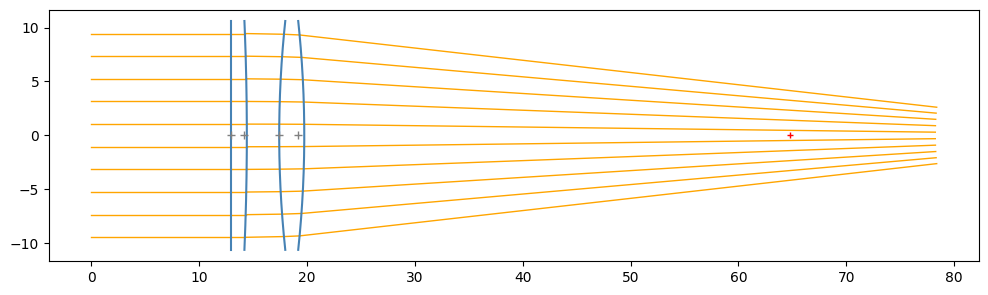

[('shape_convex_a', Parameter containing:
tensor(0.0020000001, requires_grad=True)), ('shape_biconvex_a', Parameter containing:
tensor(0.0049999999, requires_grad=True))]


[  0/250] L= 88.059 | grad norm= 43380.55859375


[ 13/250] L= 17.792 | grad norm= 16800.76953125


[ 26/250] L=  6.219 | grad norm= 7836.52783203125


[ 39/250] L=  1.742 | grad norm= 4658.04931640625


[ 52/250] L=  0.315 | grad norm= 1905.9342041015625


[ 65/250] L=  0.023 | grad norm= 651.64990234375


[ 78/250] L=  0.009 | grad norm= 90.71959686279297


[ 91/250] L=  0.011 | grad norm= 291.04132080078125


[104/250] L=  0.006 | grad norm= 131.613525390625


[117/250] L=  0.004 | grad norm= 10.30176830291748


[130/250] L=  0.004 | grad norm= 39.65920639038086


[143/250] L=  0.004 | grad norm= 7.974094390869141


[156/250] L=  0.004 | grad norm= 10.999646186828613


[169/250] L=  0.004 | grad norm= 0.9056825041770935


[182/250] L=  0.004 | grad norm= 3.0164432525634766


[195/250] L=  0.004 | grad norm= 0.6648699641227722


[208/250] L=  0.004 | grad norm= 0.5239008665084839


[221/250] L=  0.004 | grad norm= 0.3628789782524109


[234/250] L=  0.004 | grad norm= 0.07986314594745636


[247/250] L=  0.004 | grad norm= 0.047861628234386444


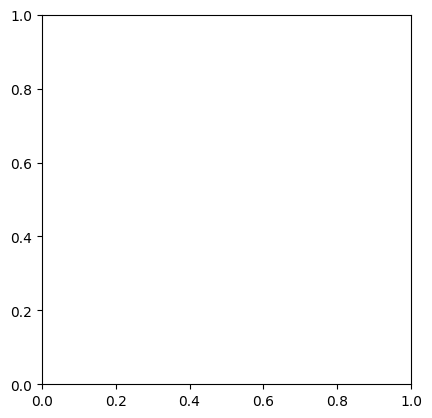

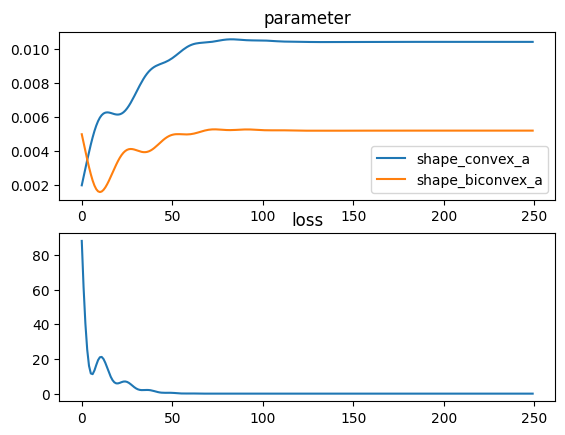

rays aperture 0.0
rays aperture 0.0
rays aperture 0.9186678
rays aperture 0.41783524
rays aperture 0.40404892


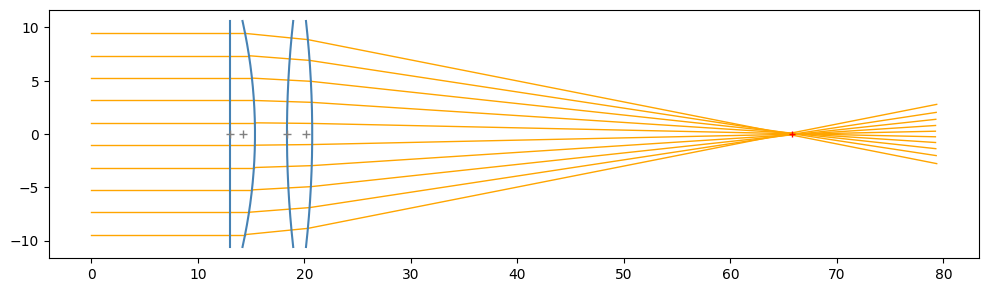

Plano-convex thickness 2.3728 0.0000 1.2000
Bi-convex thickness 2.3728 0.0000 1.2000

[Parameter containing:
tensor(0.0104246875, requires_grad=True), Parameter containing:
tensor(0.0052123801, requires_grad=True)]


In [1]:
import math
import torch
import torch.nn as nn
import numpy as np

import torch.optim as optim
import torchlensmaker as tlm


class PulaskiStack(tlm.Module):
    def __init__(self, lens_radius, focal_length, lens_min_thickness, nplano, nbiconvex, nrplano):
        super().__init__()
        
        self.shape_convex = tlm.Parabola(lens_radius, nn.Parameter(torch.tensor(0.002)))
        self.shape_biconvex = tlm.Parabola(lens_radius, nn.Parameter(torch.tensor(0.005)))
    
        self.plano = tlm.PlanoLens(
            self.shape_convex,
            n = (1.0, 1.5),
            outer_thickness = lens_min_thickness,
            reverse=True,
        )
        
        self.biconvex = tlm.SymmetricLens(
            self.shape_biconvex,
            n = (1.0, 1.5),
            outer_thickness = lens_min_thickness,
        )
    
        self.rplano = tlm.PlanoLens(
            self.shape_convex,
            n = (1.0, 1.5),
            outer_thickness = lens_min_thickness,
            reverse=False,
        )

        self.optics = tlm.OpticalSequence(
            tlm.PointSourceAtInfinity(beam_diameter=0.9*lens_radius),
            tlm.Gap(10.),
            *[
                tlm.Gap(lens_spacing),
                self.plano,
            ]*nplano,
            *[
                tlm.Gap(lens_spacing),
                self.biconvex,
            ] *nbiconvex,
            *[
                tlm.Gap(lens_spacing),
                self.rplano,
            ]*nrplano,
            tlm.Gap(focal_length),
            tlm.FocalPoint(),
        )

    def forward(self, inputs, sampling):
        return self.optics(inputs, sampling)
        

torch.set_printoptions(precision=10)


square_size = 30
lens_radius = math.sqrt(2)*square_size/2
focal_length = 45.
nplano = 1
nbiconvex = 1
nrplano = 0
lens_min_thickness = 1.2
lens_spacing = 3.


def regu_equalparam(optics):
    params = torch.cat([param.view(-1) for param in optics.parameters()])
    return torch.pow(torch.diff(1000*torch.abs(params)).sum(), 2)
    
def regu_equalthickness(optics):
    t0 = optics.plano.inner_thickness()
    t1 = optics.biconvex.inner_thickness()
    return 100*torch.pow(t0 - t1, 2)

def demo_pulaski():
    print("Lens design")
    print("Square size", square_size)
    print("Lens radius", lens_radius)
    print("Configuration", nplano, nbiconvex, nrplano)
    print("lens_min_thickness", lens_min_thickness)
    print("lens_spacing", lens_spacing)

    optics = PulaskiStack(lens_radius, focal_length, lens_min_thickness, nplano, nbiconvex, nrplano)

    tlm.render_plt(optics, force_uniform_source=False)

    print(list(optics.named_parameters()))
    
    tlm.optimize(
        optics,
        optimizer = optim.Adam(optics.parameters(), lr=5e-4),
        sampling = {"rays": 10},
        num_iter = 250,
        regularization = regu_equalthickness,
    )

    tlm.render_plt(optics, force_uniform_source=False)

    # Thickness profile
    half_square_size = square_size/2
    
    def thickness_profile(lens):
        a, c = lens.inner_thickness(), lens.outer_thickness()
        #b = parabolic_lens_thickness(lens, square_size/2)
        return a, 0.0, c

    if nplano > 0:
        print("Plano-convex thickness {:.4f} {:.4f} {:.4f}".format(*thickness_profile(optics.plano)))
    if nbiconvex > 0:
        print("Bi-convex thickness {:.4f} {:.4f} {:.4f}".format(*thickness_profile(optics.biconvex)))
    if nrplano > 0:
        print("Reverse plano-convex thickness {:.4f} {:.4f} {:.4f}".format(*thickness_profile(optics.rplano)))
    print()
    print(list(optics.parameters()))

    return optics

optics = demo_pulaski()

In [2]:
from IPython.display import display

display(tlm.lens_to_part(optics.plano))
display(tlm.lens_to_part(optics.biconvex))

Part at 0x7101f24c3fe0, label(), #children(0)

Part at 0x7103013dbaa0, label(), #children(0)